In this lab, we will be postprocessing results obtained in Thursday's stochastic optimization lab obtained with the pyplasmaopt code.

We will begin by importing various things

In [45]:
import numpy as np
import os
from coilpy import *
import sys
from simsopt.modules.vmec.input import init_modes
from simsopt.modules.vmec.output import VmecOutput
import matplotlib.pyplot as plt

We will now read in the coil_\*.txt and current_\*.txt files produced by the pyplasmaopt code

In [46]:
Ncoils = 16
nfp = 2
currents = []
names = []
groups = []
xx = [[]]; yy = [[]]; zz = [[]]
for icoil in range(Ncoils):
    filename = 'current-'+str(icoil)+'.txt'
    xx.append([]); yy.append([]); zz.append([])
    if not os.path.exists(filename) :
        raise IOError ("File not existed. Please check again!")
    with open(filename,'r') as currentfile:
        currents.append(float(currentfile.readline()))
    filename = 'coil-'+str(icoil)+'.txt'   
    with open(filename,'r') as coilfile:
        if not os.path.exists(filename) :
            raise IOError ("File not existed. Please check again!")
        for line in coilfile:
            linelist = line.split()
            xx[icoil].append(float(linelist[0]))
            yy[icoil].append(float(linelist[1]))
            zz[icoil].append(float(linelist[2]))
xx.pop()
yy.pop()
zz.pop()
            
for icoil in range(Ncoils):
    groups.append(icoil % nfp)
    names.append('Mod_'+str(groups[icoil]))
    
coilObject = coils.Coil(xx,yy,zz,currents,names,groups)

We can now plot the coilset

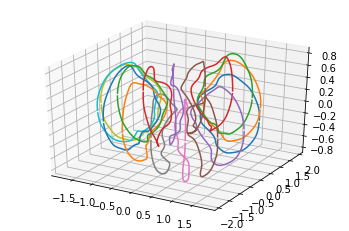

In [5]:
coilObject.plot(engine='pyplot')

We now are going to produce a coils.\* file needed to call the makegrid code (https://princetonuniversity.github.io/STELLOPT/MAKEGRID.html)

The makegrid code calculates the vacuum magnetic field produced by the coilset on a cylindrical grid

In [49]:
coilObject.save_makegrid('pyplasmaopt.coils',nfp=2)

Before we call the makegrid code, we need to compute the range of the cylindrical grid required

In [51]:
R_arr = np.sqrt(np.array(xx)**2 + np.array(yy)**2)
Z_arr = np.array(zz)
R_min = np.min(R_arr)
R_max = np.max(R_arr)
Z_min = np.min(Z_arr)
Z_max = np.max(Z_arr)
print('Rmin = '+str(R_min))
print('Rmax = '+str(R_max))
print('Zmin = '+str(Z_min))
print('Zmax = '+str(Z_max))

Rmin = 0.4466295889722326
Rmax = 1.9275626911341612
Zmin = -0.8547320187892922
Zmax = 0.8547320187892922


We will now call the makegrid code. 

1. Make a directory from which you will call makegrid. This directory should contain 
    - the coils.\* file you just produced
    - an input_xgrid.dat file (a sample can be found in the makegrid directory)
    - a batch_script file (a sample can be found in the makegrid directory)

2. Modify the input_xgrid.dat file with 
    - the correct coils.\* suffix
    - Rmin, Rmax, Zmin, Zmax

3. Call makegrid by submitting the sample batch script

We now need to generate the initial guess of the boundary of the plasma to provide to VMEC. We will read in files produced from the pyplasmaopt code

In [8]:
X = np.loadtxt('X.txt',delimiter=',')
Y = np.loadtxt('Y.txt',delimiter=',')
Z = np.loadtxt('Z.txt',delimiter=',')
varphi = np.loadtxt('theta.txt',delimiter=',')
theta = np.loadtxt('varphi.txt',delimiter=',')

R = np.sqrt(X**2 + Y**2)

# Compute cylindrical phi
phi = np.arctan2(Y,X)
phi[phi<0] = phi[phi<0]+2*np.pi

These quantities are on a grd in the poloidal angle (theta) and Boozer toroidal angle. We will now compute the R and Z cylindrical components on a regular grid in the poloidal angle and cylindrical toroidal angle by interpolating

In [53]:
nphi = len(phi[0,:])
ntheta = len(phi[:,0])
phi_grid = np.linspace(0,2*np.pi,nphi+1)
phi_grid = np.delete(phi_grid,-1,0)
theta_grid = np.linspace(0,2*np.pi,ntheta+1)
theta_grid = np.delete(theta_grid,-1,0)
[phi_2d,theta_2d] = np.meshgrid(phi_grid,theta_grid)

# Interpolate to get on regular phi grid 
R_interp = np.zeros(np.shape(R))
Z_interp = np.zeros(np.shape(Z))
for itheta in range(0,ntheta):
    R_interp[itheta,:] = np.interp(phi_grid,phi[itheta,:],R[itheta,:],period=np.pi)
    Z_interp[itheta,:] = np.interp(phi_grid,phi[itheta,:],Z[itheta,:],period=np.pi)
X_interp = R_interp*np.cos(phi_2d)
Y_interp = R_interp*np.sin(phi_2d)

We now plot the results

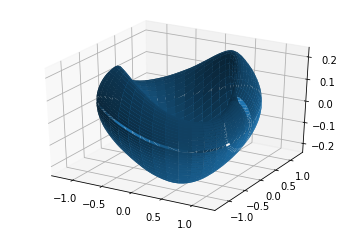

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_interp,Y_interp,Z_interp)

We will now perform a Fourier transform, as we will need to provide the boundary harmoncis to VMEC.

$R = \sum_{m,n} R_{m,n}^c \cos(m \theta - n N_P \phi) $ \
$Z = \sum_{m,n} Z_{m,n}^s \sin(m \theta - n N_P \phi) $

In [55]:
mmax = 5
nmax = 5
# m = 0 modes
[mnmax, xm, xn] = init_modes(mmax,nmax)

rbc = np.zeros(mnmax)
zbs = np.zeros(mnmax)
for im in range(mnmax):
    angle = xm[im]*theta_2d - nfp*xn[im]*phi_2d
    rbc[im] = np.sum(np.cos(angle)*R_interp)/np.sum(np.cos(angle)**2)
    if (im > 0):
        zbs[im] = np.sum(np.sin(angle)*Z_interp)/np.sum(np.sin(angle)**2)
# IFT to check
R_ift = np.zeros(np.shape(theta_2d))
Z_ift = np.zeros(np.shape(theta_2d))
for im in range(mnmax):
    angle = xm[im]*theta_2d - nfp*xn[im]*phi_2d
    R_ift += np.cos(angle)*rbc[im]
    Z_ift += np.sin(angle)*zbs[im]
R_err = np.sum(np.abs(R_ift-R_interp))/np.sum(R_interp)
Z_err = np.sum(np.abs(Z_ift-Z_interp))/np.sum(np.abs(Z_interp))
print('Error in R FT: '+str(R_err))
print('Error in Z FT: '+str(Z_err))

Error in R FT: 0.0002375566818790591
Error in Z FT: 0.002536573382550118


We will print these boundary harmonics to a file (boundary.txt) 

In [15]:
# Print boundary harmonics to a file
f = open('boundary.txt','w')
for im in range(mnmax):
    if (abs(rbc[im])>1e-10):
        f.write('rbc('+str(int(xn[im]))+','+str(int(xm[im]))+') = '+str(rbc[im])+'\n')
    if (abs(zbs[im])>1e-10):
        f.write('zbs('+str(int(xn[im]))+','+str(int(xm[im]))+') = '+str(zbs[im])+'\n')
f.close()

We will now estimate the toroidal flux through this surface by approximating $\textbf{B} \approx G \nabla \phi$, where $G = \mu_0 I/(2\pi)$ ($I$ is the sum of the coil currents) is the Boozer covariant component and $\phi$ is the cylindrical torodial angle. The toroidal cross-section area is estimated to be $A \approx \pi a^2$, where $a = R_{1,0}^c$ and $R_0 = R_{00}^c$. Thus we estimate the toroidal flux using $\Psi_T \approx \pi G a^2/R_0^2$.
- 

In [56]:
mu0 = 4*np.pi*10**(-7)
I = np.sum(np.abs(currents))
G = mu0*I/(2*np.pi)
R0 = rbc[(xm==0) * (xn==0)][0]
a = rbc[(xm==1) * (xn==0)][0]
psi = np.pi*G*a*a/(R0*R0)
print('psi = ' + str(psi))

psi = 0.0993898290818362


The caluculated value for $\Psi_T$ will be used as the input PHIEDGE for VMEC

We are now going to call free-boundary VMEC. 

1. Make a directory from which you will call the code. This directory should contain
    - The mgrid_\*.nc file you just made
    - an input.\* file (a sample can be found in the vmec directory)
    - a batch_script file (a sample can be found in the vmec directory)

2. Modify the input.\* file with
    - phiedge should be set to the esimated toroidal flux 
    - mgrid_file should be set to the correct mgrid_\*.nc file name
    - replace rbc(\*,\*) = ... and zbs(\*,\*) = ... with the text in boundary.txt
    
There are many other input parameters, most of which you do not need to worry about. Documentation on free-boundary VMEC can be found at:
https://princetonuniversity.github.io/STELLOPT/VMEC%20Free%20Boundary%20Run.html
https://princetonuniversity.github.io/STELLOPT/VMEC

3. Submit the job using the batch_script


We will now compare the result of the VMEC calculation with the pyplasmaopt calculation. We first compute the rotational transform. 

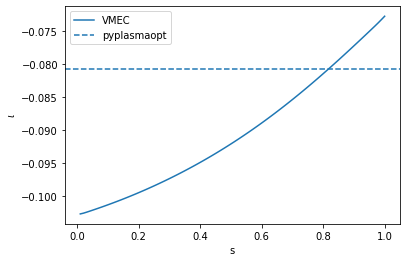

In [71]:
wout_filename = 'vmec/wout_pyplasmaopt.nc'
vmecOutput = VmecOutput(wout_filename)

# Compute iota on full mesh 
iota_half = vmecOutput.iota
iota_full = np.zeros(vmecOutput.ns_half)
iota_full[0:-1] = (vmecOutput.iota[0:-1]+vmecOutput.iota[1::])*0.5
iota_full[-1] = 1.5*vmecOutput.iota[-1]-0.5*vmecOutput.iota[-2]

iota_pyplasmaopt = np.loadtxt('iota.txt')

plt.plot(vmecOutput.s_full[1::],iota_full)
plt.axhline(iota_pyplasmaopt,linestyle='--')
plt.xlabel('s')
plt.ylabel('$\iota$')
plt.legend(['VMEC','pyplasmaopt'])
plt.savefig('compare_iota.png')

In order to compare with pyplasmaopt, we want to find the VMEC surface where $\iota$ is closest to the result from pyplasmaopt

In [82]:
index = np.argmin((iota_full-iota_pyplasmaopt)**2)
print('iota from VMEC = '+str(iota_full[index]))
print('iota from pyplasmaopt = '+str(iota_pyplasmaopt))
index += 1 # need to add 1 to account for axis

iota from VMEC = -0.08076451816600926
iota from pyplasmaopt = -0.08075206671319356


We will now compare the surfaces at this index.

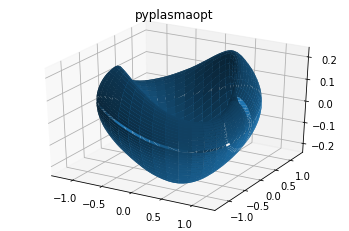

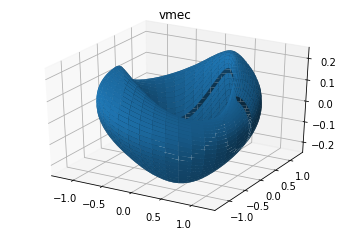

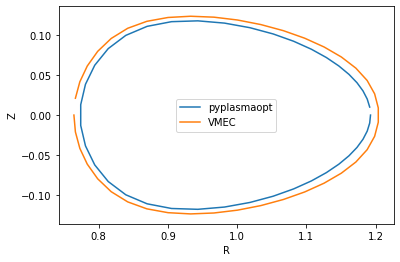

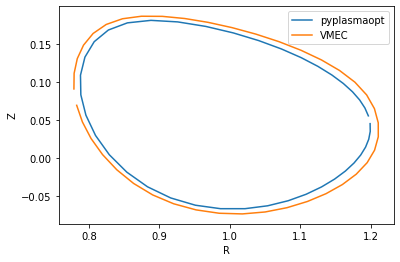

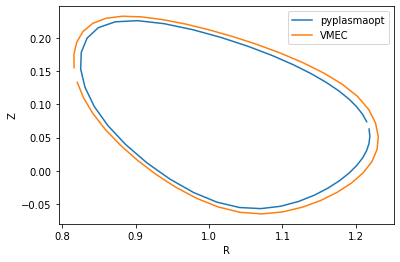

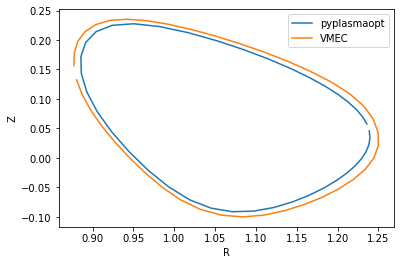

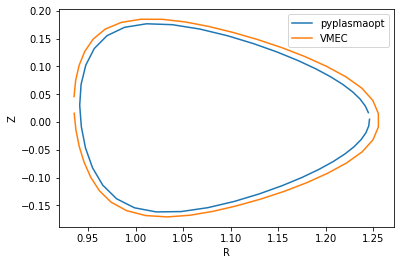

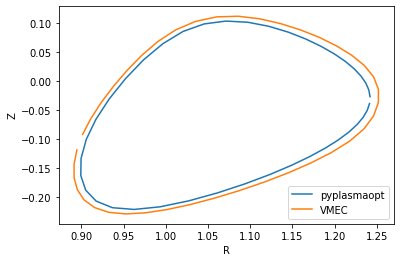

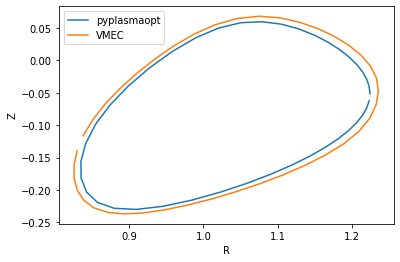

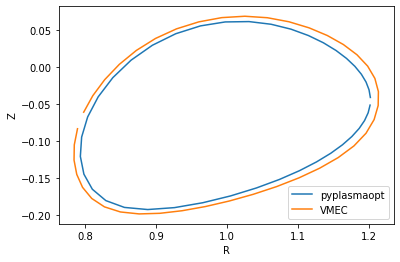

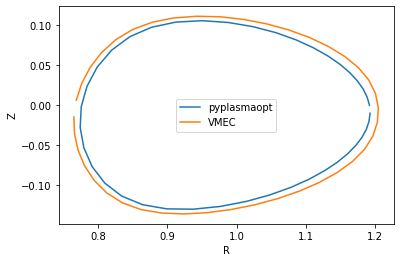

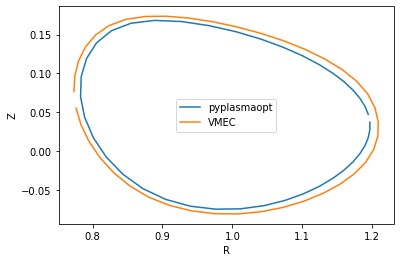

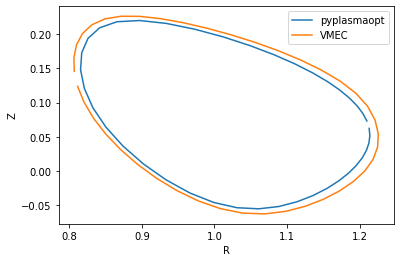

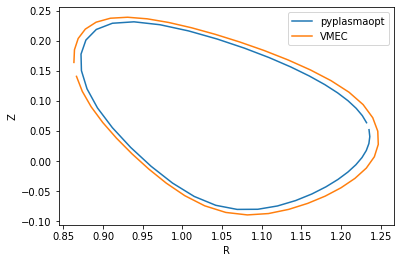

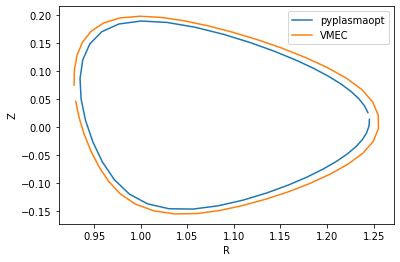

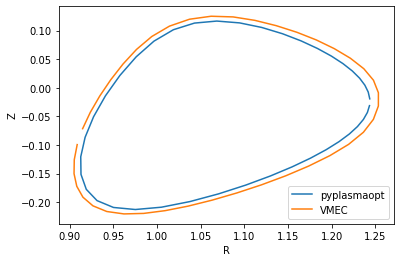

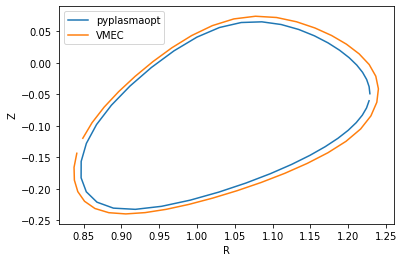

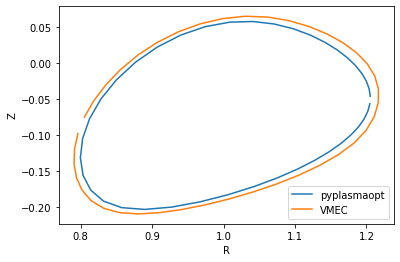

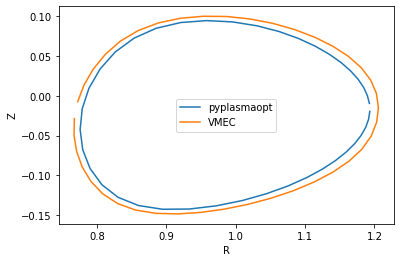

In [84]:
%matplotlib inline
[X_vmec,Y_vmec,Z_vmec,R_vmec] = vmecOutput.compute_position(isurf=index,theta=theta_2d,zeta=phi_2d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_interp,Y_interp,Z_interp)
plt.title('pyplasmaopt')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_vmec,Y_vmec,Z_vmec)
plt.title('vmec')

for iphi in range(0,nphi,5):
    plt.figure()
    plt.plot(R_interp[:,iphi],Z_interp[:,iphi])
    plt.plot(R_vmec[:,iphi],Z_vmec[:,iphi])
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.legend(['pyplasmaopt','VMEC'])

We are now going to call the boozxform code to assess the quasisymmetry near the axis. 

1. Make a directory from which you will call the code. This directory should contain
    - The wout_\*.nc file you just made
    - an in_booz.\* file (a sample can be found in the boozxform directory)
    - a batch_script file (a sample can be found in the boozxform directory)

2. Modify the in_booz.\* file with
    - the file extension of wout_\*.nc filename
   

3. Submit the job using the batch_script

Further documentation of boozxform can be found at https://princetonuniversity.github.io/STELLOPT/BOOZ_XFORM

We are now going to read the results of this calculation. The magnetic field is expressed as a Fourier series in Boozer coordinates ($\vartheta_B$,$\varphi_B$),

$B = \sum_{m,n} B_{m,n} \cos(m\vartheta_B -n N_P \varphi_B)$.


This plot will distinguish the magnitude of different classes of modes. As quasi-axisymmetry was optimized with the pyplasmaopt code, the magnitude of the $n=0$ modes should dominate the other modes.

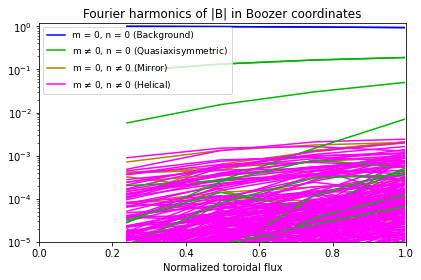

In [6]:
max_m = 10 # maximum poloidal mode number to plot
max_n = 10 # maximum toroidal mode number to plot
filename = 'boozxform/boozmn_pyplasmaopt.nc'

from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = netcdf.netcdf_file(filename,mode='r',mmap=False)

phi_b = f.variables['phi_b'][()]
ns_b = f.variables['ns_b'][()]
nfp_b = f.variables['nfp_b'][()]
ixn_b = f.variables['ixn_b'][()]
ixm_b = f.variables['ixm_b'][()]
bmnc_b = f.variables['bmnc_b'][()]
jlist = f.variables['jlist'][()]
f.close()
nmodes = len(ixn_b)

fig = plt.figure()

s = (jlist-1.5)/(ns_b-1.0)

backgroundColor='b'
QAColor=[0,0.7,0]
mirrorColor=[0.7,0.5,0]
helicalColor=[1,0,1]

scale_factor = np.max(np.abs(bmnc_b))

# First, plot just the 1st mode of each type, so the legend looks nice.

for imode in range(nmodes):
    if ixn_b[imode]==0 and ixm_b[imode]==0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=backgroundColor,label='m = 0, n = 0 (Background)')
        break
for imode in range(nmodes):
    if ixn_b[imode]==0 and ixm_b[imode]!=0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=QAColor,label=r'm $\ne$ 0, n = 0 (Quasiaxisymmetric)')
        break
for imode in range(nmodes):
    if ixn_b[imode]!=0 and ixm_b[imode]==0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=mirrorColor,label=r'm = 0, n $\ne$ 0 (Mirror)')
        break
for imode in range(nmodes):
    if ixn_b[imode]!=0 and ixm_b[imode]!=0:
        plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=helicalColor,label=r'm $\ne$ 0, n $\ne$ 0 (Helical)')
        break
plt.legend(fontsize=9,loc=2)
for imode in range(nmodes):
    if np.abs(ixm_b[imode]) > max_m:
        continue
    if np.abs(ixn_b[imode]) > max_n * nfp_b:
        continue
    if ixn_b[imode]==0:
        if ixm_b[imode]==0:
            mycolor = backgroundColor
        else:
            mycolor = QAColor
    else:
        if ixm_b[imode]==0:
            mycolor = mirrorColor
        else:
            mycolor = helicalColor
    plt.semilogy(s,abs(bmnc_b[:,imode])/scale_factor, color=mycolor)

plt.xlabel('Normalized toroidal flux')
plt.title('Fourier harmonics of |B| in Boozer coordinates')
plt.ylim([1e-5,1.2])
plt.xlim([0,1])

plt.subplots_adjust(top=0.9,bottom=0.14,left=0.09,right=0.94)

plt.show()

We will now quantify the degree of quasisymmetry by summing over all of the non-QA modes

$f_{QA} = \sqrt{\frac{\sum_{m,n\ne 0} B_{m,n}^2}{\sum_{m,n} B_{m,n}^2}}$

Text(0, 0.5, 'QA metric')

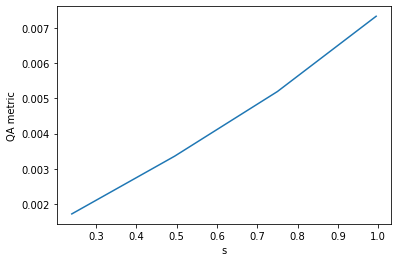

In [21]:
QA_metric = np.zeros(len(jlist))
for index in range(len(jlist)):
    summed_total = 0
    summed_nonQA = 0
    for imode in range(nmodes):
        if ixn_b[imode]!=0:
            summed_nonQA += bmnc_b[index,imode]**2
        summed_total += bmnc_b[index,imode]**2
    # Normalize by to
    QA_metric[index] = np.sqrt(summed_nonQA/summed_total)
    
plt.plot(s,QA_metric)
plt.xlabel('s')
plt.ylabel('QA metric')